"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [8]:
!file $(which python)

/Users/haozhang/python-venvs/oml/bin/python: Mach-O 64-bit executable x86_64


In [9]:
!python --version

Python 3.8.5


In [10]:
!python -m pip install -Uqqq pip setuptools wheel

In [11]:
!ls

README.md                             demo_lorenz.ipynb
demo_linear_time_varying_system.ipynb requirements.txt


In [12]:
!cat requirements.txt

ai4s.oml
numpy
scipy
matplotlib
control
slycot

In [4]:
!python -m pip install -r requirements.txt

  Using cached slycot-0.5.0.0.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for slycot: filename=slycot-0.5.0-cp38-cp38-macosx_10_16_x86_64.whl size=1939813 sha256=7001f1c878f988c5ed1209bde3c7fa165b2460aff57859fff7ce921ab01b4701
  Stored in directory: /Users/haozhang/Library/Caches/pip/wheels/b4/39/2a/32ae2ed2c02ec0e386de63474126746edf2c83b632b9d2ad44
Successfully built slycot


In [13]:
!pip list

Package            Version   Editable project location
------------------ --------- -------------------------------------
ai4s.oml           0.2.0     /Users/haozhang/Local/open-source/oml
attrs              22.1.0
bleach             5.0.1
build              0.8.0
certifi            2022.9.24
charset-normalizer 2.1.1
commonmark         0.9.1
contourpy          1.0.5
control            0.9.2
cycler             0.11.0
docutils           0.19
fonttools          4.37.4
idna               3.4
importlib-metadata 5.0.0
iniconfig          1.1.1
jaraco.classes     3.2.3
keyring            23.9.3
kiwisolver         1.4.4
matplotlib         3.6.1
more-itertools     9.0.0
numpy              1.23.4
oml                0.2.0
packaging          21.3
pep517             0.13.0
Pillow             9.2.0
pip                22.3
pkginfo            1.8.3
pluggy             1.0.0
py                 1.11.0
Pygments           2.13.0
pyparsing          3.0.9
pytest             7.1.3
python-dateutil    2.8.2
read

Uncontrolled system simulation
-  classical butterfly trajectory

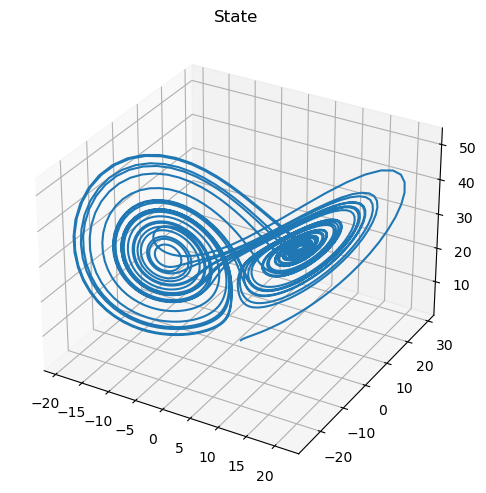

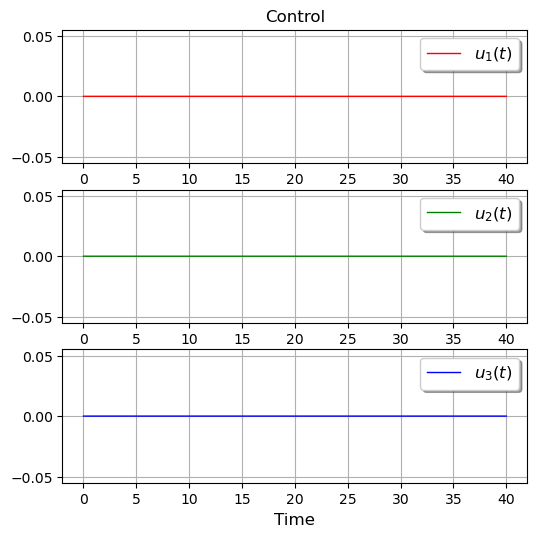

In [14]:
"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

import random
import matplotlib.pyplot as plt
import numpy as np
from oml import OnlineLinearModel
from control import lqr, StateSpace, ctrb

random.seed(20210220)
np.random.seed(20210220)

# define dynamics
# https://en.wikipedia.org/wiki/Lorenz_system
# Lorenz
n = 3 # state dimension
k = 3 # input dimension
# output = state (full state observation)
sigma = 10
beta = 8.0 / 3.0
rho = 28
def dyn(x, u):
    assert x.shape == (n,)
    assert u.shape == (k,)
    f = np.zeros(n) # dx/dt = f(x, u)
    f[0] = sigma * (x[1] - x[0]) + u[0]
    f[1] = x[0] * (rho - x[2]) - x[1] + u[1]
    f[2] = x[0] * x[1] - beta * x[2] + u[2]
    return f

# fixed point (unstable)
phi = np.sqrt(beta * (rho - 1))
xf1 = np.array([phi, phi, rho - 1])
xf2 = np.array([-phi, -phi, rho - 1])
xf3 = np.array([0, 0, 0])

# set up simulation parameter
dt = 0.01
tmax, tc = 40, 0.4
T, kc = int(tmax / dt), int(tc / dt)
tspan = np.linspace(0, tmax, T + 1)

# online linear system identification setup
alpha = 0.01 ** (1.0 / kc) # 99% decay after kc samples
olm = OnlineLinearModel(n, k, None, alpha)

# store data mtrices
x = np.zeros([n, T])
u = np.zeros([k, T])

# initial condition, state and control
x0 = np.array([1, 1, 1])
u0 = np.array([0, 0, 0])

# initial condition
x[:, 0] = x0
u[:, 0] = u0

# uncontrolled system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    u[:, t] = 0


def plot_state(x):
    plt.rcParams['figure.dpi'] = 100
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection="3d")
    ax.plot(x[0, :], x[1, :], x[2, :])
    plt.title("State")
    plt.draw()
    plt.grid()
    plt.show()


def plot_control(u):
    plt.rcParams['figure.dpi'] = 100
    fig, axs = plt.subplots(3, figsize=(6, 6))

    axs[0].plot(tspan[1:], u[0, :], "r-", linewidth=1.0, label="$u_1(t)$")
    axs[0].legend(loc="best", fontsize=12, shadow=True)
    axs[0].grid()
    axs[0].set_title("Control")

    axs[1].plot(tspan[1:], u[1, :], "g-", linewidth=1.0, label="$u_2(t)$")
    axs[1].legend(loc="best", fontsize=12, shadow=True)
    axs[1].grid()

    axs[2].plot(tspan[1:], u[2, :], "b-", linewidth=1.0, label="$u_3(t)$")
    axs[2].legend(loc="best", fontsize=12, shadow=True)
    axs[2].grid()

    axs[2].set_xlabel("Time", fontsize=12)


# plot state and control
plot_state(x)
plot_control(u)

Controlled system simulation
- Purely data-driven
- Real-time model learning
- Adaptive to new data
- Closed loop control
- Stabilizes system at unstable fixed point

In [15]:
# controlled system simulation
# we want to stabilize system at fixed point xf1
# need to shift state by -xf1

# initial condition, state and control
x[:, 0] = x0
u[:, 0] = u0

# control system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    # use new measurement to update online system identification
    # try stabilize at xf1, shift state by -xf1
    olm.update(x[:, t - 1] - xf1, u[:, t - 1], x[:, t] - xf1)
    # apply control if we have collected enough data
    if t > 4 * max(n, n + k):
        # convert to continuous representation
        Ac = (olm.A - np.eye(n)) / dt
        Bc = olm.B / dt
        # get LQR gain, output = state
        sys = StateSpace(Ac, Bc, np.eye(n), np.zeros((n, k)), dt=0)
        K, S, E = lqr(sys, 2 * np.eye(n), np.eye(k))
        # apply control
        u[:, t] = -1.0 * K.dot(x[:, t] - xf1)
        # clip control
        u[:, t] = np.clip(u[:, t], -10, 10)
        # smooth control
        w = 0.5
        u[:, t] = (1 - w) * u[:, t - 1] + w * u[:, t]
        # show progress
        if t % 1000 == 0:
            print(f"t={t * dt}")
            print(f"x(t)={x[:, t]}")
            print(f"xf1={xf1}")
            print(f"u(t)={u[:, t]}")
            print(f"Ac={Ac}")
            print(f"Bc={Bc}")
            print(f"K={K}\n")
    # random small perturbation if not enough data yet
    else:
        u[:, t] = 1e-1 * np.random.randn(k)

plot_state(x)
plot_control(u)
assert np.linalg.norm(x[:, -1] - xf1) < 1e-1

ControlSlycot: can't find slycot module 'sb02md' or 'sb02nt'

In [16]:
import slycot

ImportError: dlopen(/Users/haozhang/opt/anaconda3/lib/python3.8/site-packages/slycot/_wrapper.cpython-38-darwin.so, 2): Library not loaded: /usr/local/opt/gcc/lib/gcc/8/libgfortran.5.dylib
  Referenced from: /Users/haozhang/opt/anaconda3/lib/python3.8/site-packages/slycot/_wrapper.cpython-38-darwin.so
  Reason: image not found